In [48]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import concurrent.futures
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import .stateinterpreter
%matplotlib widget


SyntaxError: invalid syntax (<ipython-input-48-da5d69505ccb>, line 9)

In [21]:
train_val_dataset

[array([[ 0.30135287,  1.71903228,  0.87364596],
        [-2.20793367, -0.41831593,  0.04568464],
        [ 0.48360588, -0.06355432, -1.15146307],
        ...,
        [ 0.49388273, -0.97593371,  1.17638514],
        [ 0.28267465,  1.21228899, -1.51488216],
        [-2.60153086, -0.55276277,  0.43398981]]),
 array([[ 0.50863351, -1.10311809, -0.93561898],
        [ 0.58346335, -1.51967207, -0.78472874],
        [ 0.42603171,  1.12392646, -1.09132955],
        ...,
        [ 0.42457726,  0.34870804, -0.93529885],
        [ 0.30917374,  0.08723494,  1.12004454],
        [ 0.56606309, -1.31482727, -0.99387699]]),
 array([1, 0, 4, ..., 5, 2, 0]),
 array([6, 6, 2, ..., 4, 3, 6])]

In [24]:

#Lasso Path
def CV_path(dataset, C_range, l1_ratio=None, quadratic_kernel=False, **kwargs):
    
    train_in, val_in, train_out, val_out = dataset
    if quadratic_kernel:
        train_in, val_in = quadratic_kernel_featuremap(train_in), quadratic_kernel_featuremap(val_in)
    _is_lasso = kwargs.get('LASSO', False)
    try:
        del kwargs['LASSO']
    except:
        pass

    if _is_lasso:
        def _train_model(C):
            model = LogisticRegression(penalty='l1', C=C, solver='saga', multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    else:
        def _train_model(C):
            model = LogisticRegression(penalty='elasticnet', C=C, solver='saga', l1_ratio=l1_ratio, multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    
    path_data = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        fut = [executor.submit(_train_model, C) for C in C_range]
        for fut_result in concurrent.futures.as_completed(fut):
            path_data.append(fut_result.result())

    n_features = train_in.shape[1]
    C_range, coeffs, crossval = np.empty_like(C_range), np.empty((C_range, n_features), np.empty_like(C_range) 

    for idx, data in enumerate(path_data):
        C_range[idx] = data[0]
        coeffs[idx] = np.squeeze(data[1])
        crossval[idx] = data[2]

    sort_perm = np.argsort(C_arr)

    return C_range[sort_perm], coeffs[sort_perm], crossval[sort_perm]

In [ ]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
n_examples = train_val_dataset[0].shape[0]
_, coeffs_LASSO, CV_LASSO = CV_path(train_val_dataset, C_range/n_examples, quadratic_kernel=False, **kwargs)

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
from matplotlib.gridspec import GridSpec

Features relevant to recognize state 0:
SIDECHAIN cos_chi1 TYR2
SIDECHAIN cos_chi1 ASP3
Features relevant to recognize state 1:
SIDECHAIN sin_chi1 THR6
SIDECHAIN cos_chi1 THR8
Features relevant to recognize state 2:
Features relevant to recognize state 3:
SIDECHAIN sin_chi1 THR6
SIDECHAIN cos_chi1 THR8


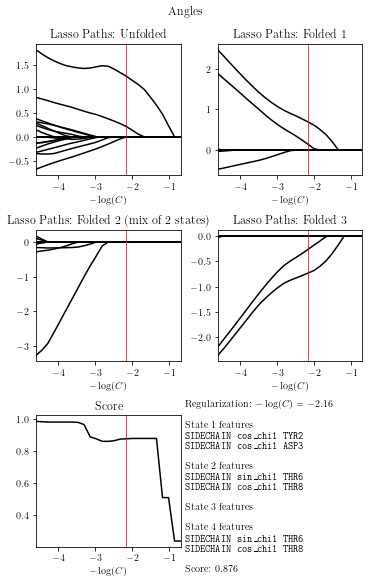

In [16]:
state_names= ['Unfolded', 'Folded 1', 'Folded 2 (mix of 2 states)', 'Folded 3']
descs = [f'Lasso Paths: {state_names[idx]}' for idx in range(coeffs_LASSO.shape[1])]
#colors = ['k', 'r--', 'g-']


fig = plt.figure(constrained_layout=True, figsize=(5,8))

gs = GridSpec(3, 2, figure=fig)

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1]))
axes.append(fig.add_subplot(gs[2, 0]))

C= np.exp(2.1)
C_idx = np.argmin(np.abs(C_range - C))
selected_coefficients = coeffs_LASSO[C_idx]
string = f'\n Regularization: $-\log(C) = {np.around(-np.log(C_range[C_idx]),decimals = 2)}$\n'
for state_idx, coef in enumerate(selected_coefficients):
    sparse_coef = csr_matrix(coef)
    model_idxs = sparse_coef.indices
    print(f"Features relevant to recognize state {state_idx}:")
    string += f"\nState {state_idx + 1} features\n"
    for feat_idx in model_idxs:
        #string += '\\texttt{' + decode_quadratic_features(feat_idx, features_names)+'}\n'
        print(features_names[feat_idx] )
        string += '\\texttt{' + features_names[feat_idx] +'}\n'
string = string.translate(str.maketrans({"_":  r"\_"}))  
fig.suptitle('Angles')
for idx in range(coeffs_LASSO.shape[1]):
    ax = axes[idx]
    ax.plot(np.log(1/C_range), coeffs_LASSO[:,idx,:], 'k-')
    ax.axvline(x = np.log(1/C_range[C_idx]), color='r', linewidth=0.75)
    ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
    ax.set_xlabel(r"$-\log(C)$")
    ax.set_title(descs[idx])
    
ax = axes[-1]
ax.plot(np.log(1/C_range), CV_LASSO, 'k-')
ax.axvline(x = np.log(1/C_range[C_idx]), color='r', linewidth=0.75)
ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
ax.set_xlabel(r"$-\log(C)$")
ax.set_title("Score")
string += f'\nScore: {CV_LASSO[C_idx]}'
fig.text(0.5,0.33, string, va='top');
#plt.savefig('chignolin_unbiased_figs/lasso_paths_angles.pdf')

In [24]:
def get_features(C, coeffs_LASSO, C_range, features_names):
    #Find idx of C_range closer to C
    C_idx = np.argmin(np.abs(C_range - C))
    selected_coefficients = coeffs_LASSO[C_idx]
    relevant_features = []
    for state_idx, coef in enumerate(selected_coefficients):
        sparse_coef = csr_matrix(coef)
        model_idxs = sparse_coef.indices
        print(f"Features relevant to recognize state {state_idx}:")
        state_feats = []
        for feat_idx in model_idxs:
            feature = features_names[feat_idx]
            print(f'\t{feature}')
            state_feats.append((feature, feat_idx))
        relevant_features.append(state_feats)
    return relevant_features

In [25]:
features = get_features(np.exp(1.5), coeffs_LASSO, C_range, features_names)
features

Features relevant to recognize state 0:
	sin_phi-8
	cos_psi-7


IndexError: index 1425 is out of bounds for axis 0 with size 68

Features relevant to recognize state 0:
sin_phi-8 || sin_phi-8
cos_psi-7 || cos_psi-7
cos_psi-4 || sin_psi-4
cos_psi-5 || sin_psi-5
cos_psi-6 || sin_psi-6
cos_chi1-2
cos_chi1-3
Features relevant to recognize state 1:
sin_chi1-6
Features relevant to recognize state 2:
sin_chi1-6
cos_chi1-8
Features relevant to recognize state 3:
sin_chi1-6 || cos_chi1-8


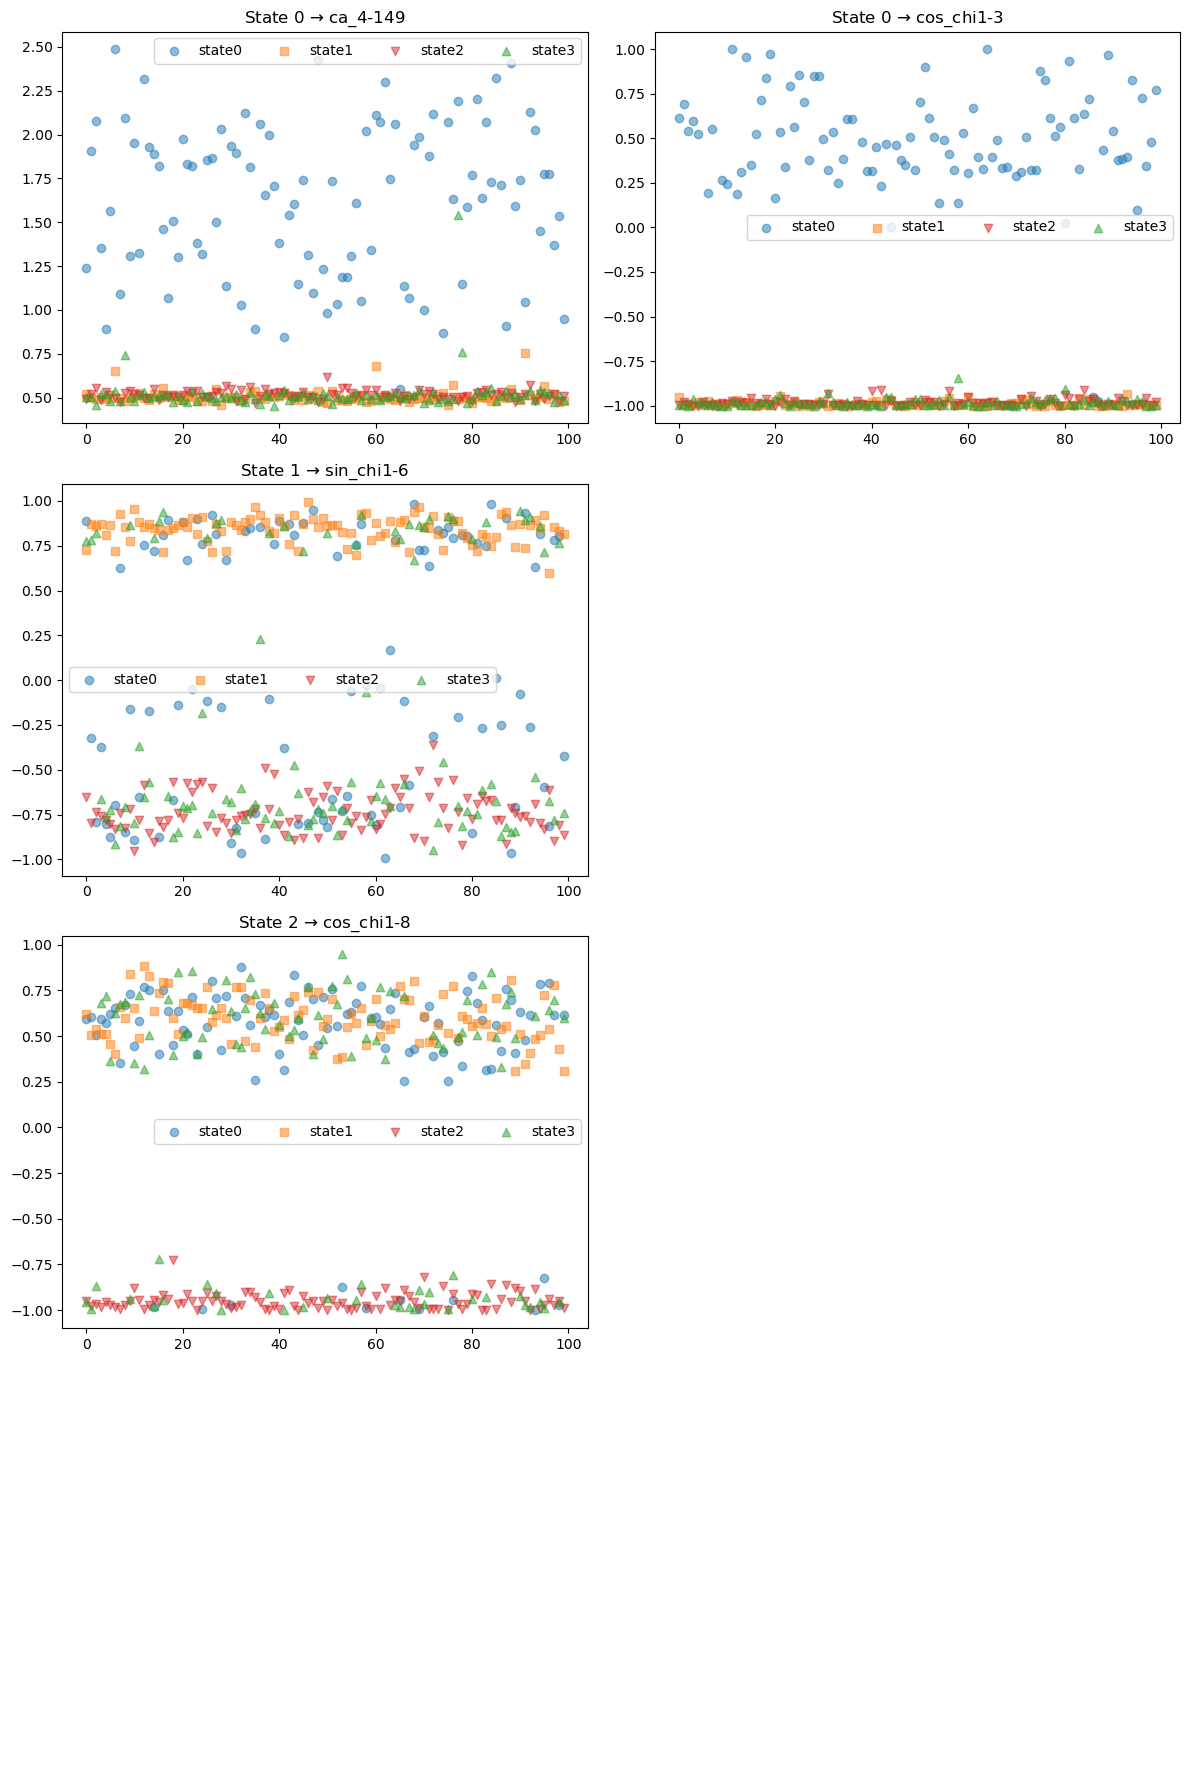

In [30]:
#features = [['dd_32-119', 'dd_32-125'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8']]

nrows=4
ncols=2

fig,axs=plt.subplots(nrows,ncols,figsize=(12,18),dpi=100)

colors=['tab:blue','tab:orange','tab:red','tab:green']
markers=['o','s','v','^']

for i in range(4):
    for j,feature_tuple in enumerate(features[i]):
        feature, feat_idx = feature_tuple
        ax = axs[i,j]
        ax.set_title(r'State '+str(i)+r' $\to$ '+feature)
        for k,config in enumerate(config_list):
            ax.scatter(np.arange(config.shape[0])[:100],config[:100,feat_idx],label='state'+str(k),alpha=0.5,color=colors[k],marker=markers[k])
        ax.legend(ncol=4)
        
    for j in range(len(features[i]),ncols):
        axs[i,j].axis('off')
plt.tight_layout()

### Experiment: using polynomial kernel to distinguish state 3

In [49]:
from scipy.spatial.distance import squareform
from tqdm import tqdm

def quadratic_kernel_featuremap(X):
    n_pts, n_feats = X.shape
    n_feats +=1
    transformed_X = np.empty((n_pts, n_feats + n_feats*(n_feats - 1)//2), dtype=np.float_)
    X = np.c_[X, np.ones(n_pts)]
    
    def _compute_repr(x):
        mat = np.outer(x,x)
        diag = np.diag(mat)
        mat = (mat - np.diag(diag))*np.sqrt(2)
        off_diag = squareform(mat)
        return np.r_[diag, off_diag]
    for idx, x in tqdm(enumerate(X),total=n_pts):
        transformed_X[idx] = _compute_repr(x)
    return transformed_X
def decode_quadratic_features(idx, features_names):
    num_feats = features_names.shape[0]
    s = ''
    if idx < num_feats:
        s = f"{features_names[idx]} || {features_names[idx]}"
    elif idx > num_feats:
        rows, cols = np.triu_indices(num_feats + 1, k = 1)
        offset_idx  = idx -  num_feats - 1
        i, j = rows[offset_idx], cols[offset_idx]
        if i == num_feats:
            s = f"{features_names[j]}"
        elif j == num_feats:
            s = f"{features_names[i]}"
        else:
            s = f"{features_names[i]} || {features_names[j]}"
    print(s)
    return s

In [17]:
n_examples = train_val_dataset[0].shape[0]
C = np.exp(1)/n_examples
train_in, val_in, train_out, val_out = train_val_dataset
train_in, val_in = quadratic_kernel_featuremap(train_in), quadratic_kernel_featuremap(val_in)

100%|██████████| 500/500 [00:00<00:00, 8003.45it/s]


In [18]:
model = LogisticRegression(penalty='l1', C=C, solver='saga', multi_class="multinomial", fit_intercept=False, max_iter=1000) 
#Model Fit
model.fit(train_in,train_out)
score = model.score(val_in,val_out)

In [19]:
for state_idx, coef in enumerate(model.coef_):
    sparse_coef = csr_matrix(coef)
    model_idxs = sparse_coef.indices
    print(f"Features relevant to recognize state {state_idx}:")
    for feat_idx in model_idxs:
        decode_quadratic_features(feat_idx, features_names)

Features relevant to recognize state 0:
cos_psi-7-cos_psi-7
cos_psi-4 || sin_psi-4
cos_psi-5 || sin_psi-5
cos_psi-6 || sin_psi-6
cos_chi1-3
Features relevant to recognize state 1:
sin_chi1-6
Features relevant to recognize state 2:
cos_chi1-8
Features relevant to recognize state 3:
sin_chi1-6 || cos_chi1-8


In [10]:
features_names.shape[0]

68

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))